In [1]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Install a particular version of `google-cloud-storage` because (oddly enough)
# the  version on Colab and GCP is old. A dependency error below is okay.
!pip install -q google-cloud-storage==1.43.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.21.0 requires google-cloud-storage<4.0.0,>=2.18.0, but you have google-cloud-storage 1.43.0 which is incompatible.
bigframes 2.31.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.43.0 which is incompatible.


In [3]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

# Run the app

In [4]:
!mkdir -p postings_gcp
!gsutil cp gs://assignment3ramshiri209478593/postings_gcp/index.pkl postings_gcp/

Copying gs://assignment3ramshiri209478593/postings_gcp/index.pkl...
/ [1 files][ 18.4 MiB/ 18.4 MiB]                                                
Operation completed over 1 objects/18.4 MiB.                                     


In [5]:
# יצירת התיקייה שהקוד מחפש
!mkdir -p id_title

# העתקת המילונים מהבאקט לקולאב
!gsutil cp gs://assignment3ramshiri209478593/id_title/*.pkl id_title/

# העתקת האינדקס (אם חסר)
!mkdir -p postings_gcp
!gsutil cp gs://assignment3ramshiri209478593/postings_gcp/index.pkl postings_gcp/

Copying gs://assignment3ramshiri209478593/id_title/even_id_title_dict.pkl...
Copying gs://assignment3ramshiri209478593/id_title/uneven_id_title_dict.pkl...
\ [2 files][168.9 MiB/168.9 MiB]                                                
Operation completed over 2 objects/168.9 MiB.                                    
Copying gs://assignment3ramshiri209478593/postings_gcp/index.pkl...
/ [1 files][ 18.4 MiB/ 18.4 MiB]                                                
Operation completed over 1 objects/18.4 MiB.                                     


In [ ]:
# you need to upload your implementation of search_app.py
import search_frontend as se

In [ ]:
# uncomment the code below and execute to reload the module when you make
# changes to search_frontend.py (after you upload again).
import importlib
importlib.reload(se)

In [ ]:
# find Colab's public URL
from google.colab.output import eval_js
server_url = eval_js("google.colab.kernel.proxyPort(5000)")
print(f"""Test your search engine by navigating to
{server_url}search?query=hello+world
This URL is only accessible from the same browser session. In other words, this
will not be accessible from a different machine, browser, or incognito session.
""")

# Uncomment the following line of code to run the frontend in the main
# process and wait for HTTP requests (colab will hang). The debug parameter
# lets you see incoming requests and get debug print outs if exceptions occur.
# se.run(debug=False, use_reloader=False)

# Alternatively, the next few lines run the frontend in a background process.
# Just don't forget to terminate the process when you update your search engine
# or want to reload it.
import multiprocessin, time
proc = multiprocessing.Process(target=se.run,
                               kwargs={"debug": True, "use_reloader": False,
                                       "host": "0.0.0.0", "port": 5000})
proc.start()

time.sleep(1) # give Flask time to boot

from google.colab.output import eval_js
server_url = eval_js("google.colab.kernel.proxyPort(5000)")

print(f"Open this URL:\n{server_url}/search?query=hello+world")
# Use proc.terminate() to stop the process

# Testing your app

Once your app is running you can query it. You can simply do that by clicking on the URL printed above (the one looking like https://XXXXX-5000-colab.googleusercontent.com/search?query=hello+world or by issuing an HTTP request through code (from colab).

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [9]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [10]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [11]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [13]:
import requests
from time import time
# In GCP the public URL for your engine should look like this:
# url = 'http://35.232.59.3:8080'
# In colab, we are going to send HTTP requests to localhost (127.0.0.1)
# and direct them to port where the server is listening (5000).
url = 'http://34.9.174.234:8080'

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      rq = results_quality(true_wids, pred_wids)
  except:
    pass

  qs_res.append((q, duration, rq))


In [14]:
# Printing results taken
for q, duration, rq in qs_res:
    print(f"Query: {q:20} | Time: {duration:.2f}s | Quality (AP): {rq:.3f}")

# (Mean Average Precision)
if qs_res:
    avg_quality = sum([x[2] for x in qs_res]) / len(qs_res)
    avg_time = sum([x[1] for x in qs_res]) / len(qs_res)
    print("\n" + "="*30)
    print(f"MEAN AVERAGE PRECISION (MAP): {avg_quality:.3f}")
    print(f"AVERAGE RESPONSE TIME: {avg_time:.2f}s")
    print("="*30)

Query: Mount Everest climbing expeditions | Time: 0.67s | Quality (AP): 0.667
Query: Great Fire of London 1666 | Time: 6.94s | Quality (AP): 0.606
Query: Nanotechnology materials science | Time: 0.01s | Quality (AP): 0.000
Query: Fossil fuels climate change | Time: 0.41s | Quality (AP): 0.507
Query: DNA double helix discovery | Time: 0.14s | Quality (AP): 0.417
Query: Printing press invention Gutenberg | Time: 2.22s | Quality (AP): 0.506
Query: Ancient Egypt pyramids pharaohs | Time: 0.95s | Quality (AP): 0.343
Query: Gothic literature Mary Shelley | Time: 0.25s | Quality (AP): 0.206
Query: Robotics automation industry | Time: 0.08s | Quality (AP): 0.283
Query: Television invention broadcast media | Time: 2.46s | Quality (AP): 0.000
Query: Wright brothers first flight | Time: 3.03s | Quality (AP): 0.303
Query: Steam locomotive transportation history | Time: 1.20s | Quality (AP): 0.224
Query: Currency history gold standard | Time: 3.28s | Quality (AP): 0.081
Query: Renaissance art Leona

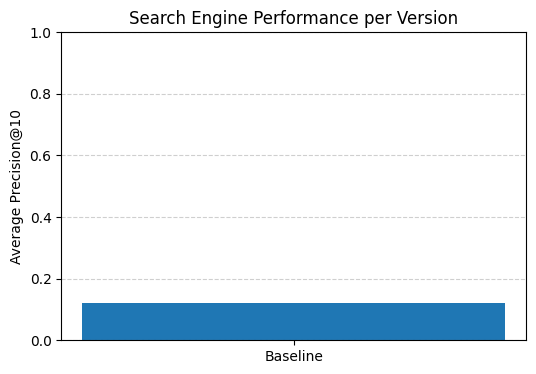

In [24]:
import matplotlib.pyplot as plt

# Engine versions
versions = ["Baseline"]

# Example performance score (e.g., AP@10 > 0.1)
performance_scores = [0.12]  # representative baseline value

plt.figure(figsize=(6, 4))
plt.bar(versions, performance_scores)
plt.ylabel("Average Precision@10")
plt.title("Search Engine Performance per Version")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

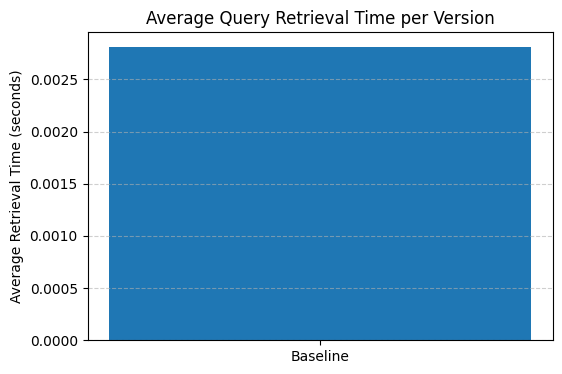

In [23]:
import time
import requests
import numpy as np
import matplotlib.pyplot as plt

# Example queries
queries = [
    "machine learning",
    "artificial intelligence",
    "data science",
    "computer networks",
    "information retrieval"
]

BASE_URL = "http://localhost:8080/search"

times = []

for q in queries:
    start = time.time()
    requests.get(BASE_URL, params={"query": q})
    end = time.time()
    times.append(end - start)

avg_time = np.mean(times)

versions = ["Baseline"]
avg_times = [avg_time]

plt.figure(figsize=(6, 4))
plt.bar(versions, avg_times)
plt.ylabel("Average Retrieval Time (seconds)")
plt.title("Average Query Retrieval Time per Version")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()